## User Example

This notebook outlines the steps needed to use Syndat to generate a set of reduced experimental Transmission data for evaluating total neutron cross sections.

The primary user controls of interest are likely:
- energy grid structure
- total noise amount
- the spin groups to be considered
- the average parameter values for each of the spin groups

These can all be controlled within this script. Just few sections down you can define the **energy grid, spin groups, and average parameters**. The **noise level** is controlled later in the section titles "Run the experiment and Analyze"


In [1]:
import numpy as np
import syndat
import pandas as pd
import os
from matplotlib.pyplot import *

In [2]:
%matplotlib widget

### Define the particle-pair of interest

The particle pair class in syndat characterizes the reaction taking place. 

The method "map_quantum_numbers" will calculate (and print if print_out=True) the open reaction channels for given a maximum number of orbital angular momenta to consider. This can be used to visualize the spin groups that may be present in a cross section.

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = syndat.particle_pair(ac, M, m, I, i, l_max)

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1.0])
(-4.0, 2, [1.0, 1.0])
(-3.0, 2, [1.0, 1.0])
(-2.0, 1, [1.0])
(3.0, 1, [0.0])
(4.0, 1, [0.0])


## Define an energy grid and average resonance parameters

Here the user defines the primary parameters for the cross section they want to use. This includes:
- energy grid structure
- spin groups
- average parameter values for those spin groups

The spin group data can be re-defined to focus on a specific set of spin groups, or the "J" attribute of the particle_pair defined above can be used directly if you want to include all spin groups up to a given order of waveform.

* Note:
    The noise level is controlled with the trig parameter which is analogous to the time of measurment (more time better statistics). This is an input to the experiment class and can be edited a few code sections below.

* Note:
    Defining a linear energy grid will result in a wild binning stucture in tof. Consider defining a tof grid instead. In practice, the tof grid has a handful (5 or so) different bin widths and a constant bin width between each point of compresssion. This is due to the artisinal nature of this process, a complicated binning stucture is less justifiable, difficult to store in EXFOR, and requires the use of a complicated resolution broadening function.

In [4]:
# # define energy grid in eV - note that this approach creates a crazy tof bin width structure
energy_grid = np.linspace(1,100,1000)

# spin_groups variable here is equivalent to Ta_pair.J
spin_groups = [ (3.0,1,[0]), (4.0,1,[0]), (-4.0,2,[1.0, 1.0])]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':20.0, '4.0':15.0, '-4.0':15.0},
                                    'Gg'    :   {'3.0':55.0, '4.0':55.0, '-4.0':55.0},
                                    'gn2'    :   {'3.0':20.0, '4.0':10.0, '-4.0':10.0}  })


### Sample a ladder of resonances parameters using Syndat

In [5]:

resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

# # look at your resonance ladder
resonance_ladder

,E,Gg,gnx2,J,chs,lwave,J_ID
0,4.554676,56.655347,7.49472,3.0,1,[0],1
1,44.479399,54.111271,17.653135,3.0,1,[0],1
2,59.892475,58.291919,53.844675,3.0,1,[0],1
3,71.60257,54.264153,23.825312,3.0,1,[0],1
4,96.86987,53.164085,9.488296,3.0,1,[0],1
5,18.332298,52.438471,0.746938,4.0,1,[0],2
6,22.652201,54.489241,9.236318,4.0,1,[0],2
7,26.740855,53.387782,6.591321,4.0,1,[0],2
8,50.224759,54.689588,4.657016,4.0,1,[0],2
9,63.331107,52.075414,2.747703,4.0,1,[0],2


### Calculate a theoretical cross section from the resonance ladder

The theoretical cross section can be calculated using the syndat code. The output total cross section must be converted to a transmission and stored in a dataframe with keys "E" and "theo_trans" before it can be passed to the experiment. The experiment object turns a theoretical cross section to a corresponding set of experimental Transmission data.

Transmission is related to total cross section in the following way:

$T = e^{-n*\sigma_t} $

Where n is the thickness of the target in unites atoms/barn.

Text(0.5, 0.01, 'Energy (eV)')

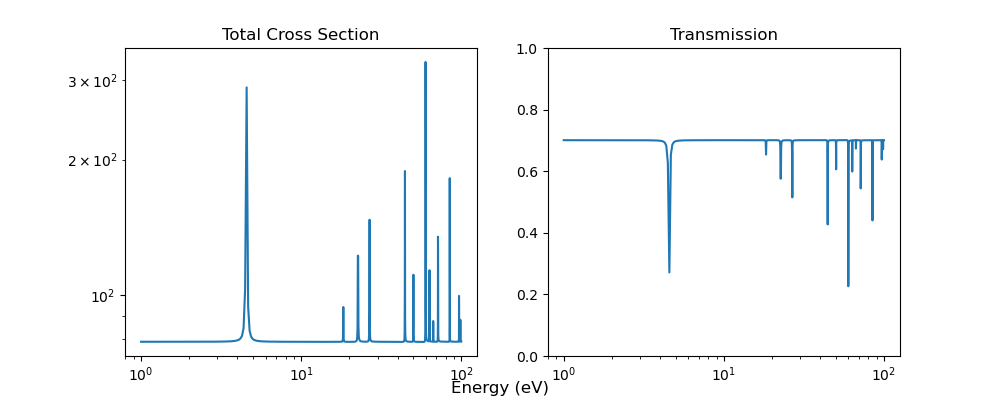

In [6]:

# SLWB with syndat
xs_tot, xs_scat, xs_cap = syndat.scattering_theory.SLBW(energy_grid, Ta_pair, resonance_ladder)

# convert to transmisison and put in an appropriate dataframe
n = 0.067166**2 # atoms per barn or atoms/(1e-12*cm^2)
trans = np.exp(-n*xs_tot)
theoretical_df = pd.DataFrame({'E':energy_grid, 'theo_trans':trans})

fig, ax = subplots(1,2, figsize=(10,4))
# ax[0].plot(energy_grid, xs_scat)
# ax[0].plot(energy_grid, xs_cap)
ax[0].plot(energy_grid, xs_tot)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Total Cross Section')

ax[1].plot(theoretical_df.E, theoretical_df.theo_trans)
ax[1].set_xscale('log')
ax[1].set_ylim([0,1])
ax[1].set_title('Transmission')

fig.supxlabel('Energy (eV)')

### Define an approximation to the open count rate spectra

An exponential function was fit to the open count rate from Brown, et al. 
This fitted function is used to approximate an open count rate spectra that would be seen in a similar tranmission tof experiment while storing it as a function allows the user to specify the energy grid and count time.

This block of code can largely be ignored, there are plans to integrate this intor the experiment class. The only pertinent user input is the energy grid.

In [7]:
def open_count_rate(tof):
    return (2212.70180199 * np.exp(-3365.55134779 * tof*1e-6) + 23.88486286) 


# convert energy grid of interest to tof
tof = syndat.exp_effects.e_to_t(energy_grid,35.185,True)*1e6 # microseconds

# calculate a tof count rate spectra, convert to counts, 
cps_open = open_count_rate(tof)
bin_width = np.append(-np.diff(tof), -np.diff(tof)[-1])*1e-6
trig = 9760770
cts_open = cps_open*bin_width*trig
cts_open_noisy = syndat.pois_noise(cts_open)
cps_open_noisy = cts_open_noisy/bin_width/trig

open_dataframe = pd.DataFrame({'tof'    :   tof,
                                'bw'    :   bin_width,
                                'c'     :   cts_open_noisy,
                                'dc'    :   np.sqrt(cts_open_noisy)})


### Run the experiment & Analyze

The Syndat experiment object has a number of methods that generate raw count data from the theoretical cross section through a novel method developed by Walton, et al. The synthesized raw count data is then reduced to get an experimentally noise data with propagated uncertainty. This is stored in the "trans" attribute of the experiment object.

A set of default experimental parameters is already loaded into the experiment class, however, if the user wants to re-define any this can be done by passing in a new_parameteres dictionary. The format for this is shown below. The example is that of the "trig" parameter. This corresponds to the number of LINAC triggers in the experiment which is proportional to the length of the measurement. Therefore, this parameter will control the noise level seen in the data.

In practice, generally the transmission data is what is fit with R-Matrix theory. 

In [8]:
options = { 'Perform Experiment':True,
            'Add Noise': True}

new_parameters = {'trig': {'val':9000000,    'unc'   :   0}}

exp = syndat.experiment(open_dataframe, theoretical_df, 
                                        options=options, 
                                        experiment_parameters=new_parameters)

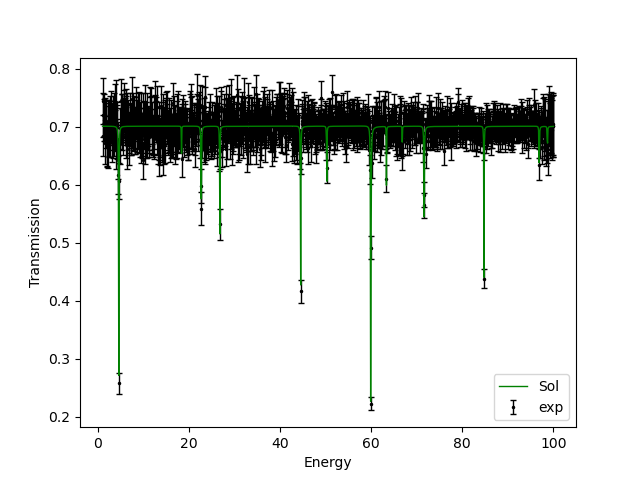

In [9]:
figure()
# plot(exp.trans.tof, exp.trans.exp_trans, '.', ms=1, label='exp')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

### Output in SAMMY format

The data in the experiment object can be accessed directly, or Syndat has a set of utilities to write (and read) SAMMY formatted data files.

In this example, the sammy.dat file will contain the experimental data while the sammy.par file will contain the theoretical parameters from which the data was generated.

In [10]:
syndat.write_samdat(exp.trans,"./test_sammy.dat")
syndat.sammy_interface.write_sampar(resonance_ladder, Ta_pair, False, "./test_sammy.par")